## Nigerian Traffic Crashes (2020-24)

<b>Description</b>

This dataset offers a detailed examination of road traffic crashes in Nigeria, covering the period from Q4 2020 to Q1 2024. It includes quarterly data on the total number of crashes, injuries, fatalities, and vehicles involved, along with key contributing factors such as speed violations, driving under the influence, and poor weather conditions. The data is sourced from official traffic records and provides insights into the factors influencing road safety in Nigeria.

Complete description can be found here on Kaggle: https://www.kaggle.com/datasets/akinniyiakinwande/nigerian-traffic-crashes-2020-2024.

In [100]:
# imports

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

### EDA

In [27]:
# generic data loading

path = os.getcwd()
path = path.split('src')[0]
path = os.path.join(path,'data/')
path = os.path.join(path,os.listdir(path)[0])
df_orig = pd.read_csv(path)
df = df_orig.copy()
df.head()

,Quarter,State,Total_Crashes,Num_Injured,Num_Killed,Total_Vehicles_Involved,SPV,DAD,PWR,FTQ,Other_Factors
0,Q4 2020,Abia,30,146,31,37,19,0,0,0,18
1,Q4 2020,Adamawa,77,234,36,94,57,0,0,0,37
2,Q4 2020,Akwa Ibom,22,28,7,24,15,0,0,1,8
3,Q4 2020,Anambra,72,152,20,83,43,1,0,0,39
4,Q4 2020,Bauchi,154,685,90,140,74,0,0,0,66


In [28]:
# checking for null values and datatypes of variables

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 518 entries, 0 to 517
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Quarter                  518 non-null    object
 1   State                    518 non-null    object
 2   Total_Crashes            518 non-null    int64 
 3   Num_Injured              518 non-null    int64 
 4   Num_Killed               518 non-null    int64 
 5   Total_Vehicles_Involved  518 non-null    int64 
 6   SPV                      518 non-null    int64 
 7   DAD                      518 non-null    int64 
 8   PWR                      518 non-null    int64 
 9   FTQ                      518 non-null    int64 
 10  Other_Factors            518 non-null    int64 
dtypes: int64(9), object(2)
memory usage: 44.6+ KB


The above output shows that the dataset is pretty clean with no missing values and consistent data type in each column. Here, we can pick any of Total_Crashes, Num_Injured, Num_Killed as the target variable, and the features form the rest of the columns.

Now, we will quickly have a look at the description of the dataframe:

In [29]:
df.describe()

,Total_Crashes,Num_Injured,Num_Killed,Total_Vehicles_Involved,SPV,DAD,PWR,FTQ,Other_Factors
count,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000,518.000000
mean,83.517375,245.631274,40.600386,100.667954,37.903475,0.140927,0.355212,23.824324,38.444015
std,77.023061,201.131483,36.858302,108.567113,57.093042,0.454320,1.677385,51.024267,61.983992
min,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-348.000000
25%,30.000000,96.250000,15.000000,32.000000,0.000000,0.000000,0.000000,0.000000,12.000000
50%,58.000000,185.500000,30.000000,64.000000,15.000000,0.000000,0.000000,0.000000,27.000000
75%,107.750000,331.500000,55.750000,134.750000,55.000000,0.000000,0.000000,21.000000,57.000000
max,538.000000,1149.000000,224.000000,864.000000,340.000000,4.000000,25.000000,425.000000,586.000000


One anomaly in the dataset is detected due to the negative minimum valiue in the column Other_Factors. We can either clean up the data by removing those rows, or avoid using Other_Factors altogether. For the time being we will just record the number of such instances and leave the rest as per further requirements. The below filter shows that there are 36 such rows, and upon further observation it was found that all of these values are from Q3 2022, which indicates some fault in recording the data.

In [60]:
display(df[df['Other_Factors']<0].head())
print('No. of rows with negative Other_Factors:',len(df[df['Other_Factors']<0]))

,Quarter,State,Total_Crashes,Num_Injured,Num_Killed,Total_Vehicles_Involved,SPV,DAD,PWR,FTQ,Other_Factors
259,Q3 2022,Abia,24,101,9,2,0,0,0,22,-20
260,Q3 2022,Adamawa,32,72,3,0,0,0,0,21,-21
261,Q3 2022,Akwa Ibom,22,55,9,0,0,0,0,20,-20
262,Q3 2022,Anambra,42,103,20,3,1,0,0,19,-17
263,Q3 2022,Bauchi,129,436,94,8,0,0,1,98,-91


No. of rows with negative Other_Factors: 36


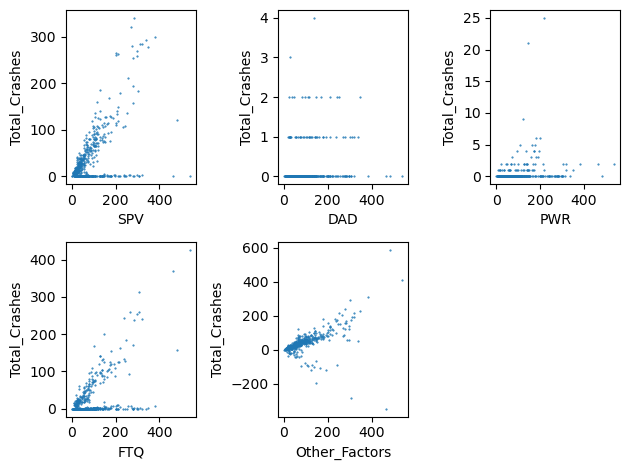

In [56]:
# scatter plots

features = df.columns[-5:]
variables = ['Total_Crashes', 'Num_Injured', 'Num_Killed']

# enter the index number of the chosen target variable in the list variables
var_index = 0
for i in enumerate(features):
    plt.subplot(2,3,i[0]+1)
    plt.scatter(df[variables[var_index]],df[i[1]],s=0.25)
    plt.xlabel(i[1])
    plt.ylabel(variables[var_index])
    plt.tight_layout()

From these scatter plots (univariate analysis), following observations can be made:
1. SPV, FTQ and Other_Factors are strong features to predict the Total_Crashes, even if used one at a time.
2. Indications of zero inflation are clearly visible in the data.

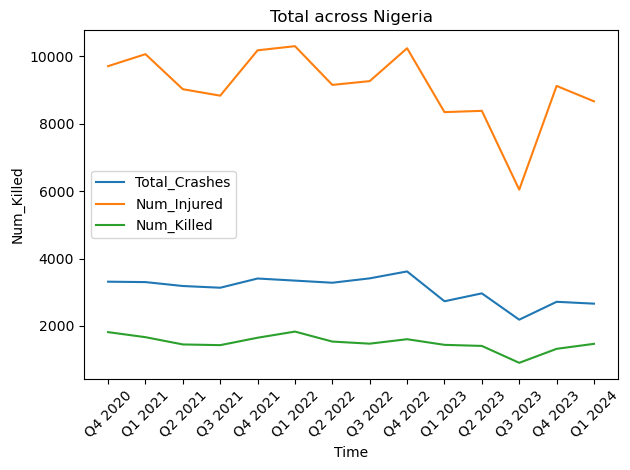

In [95]:
# tracking temporal changes

groups = df.groupby(by=['Quarter'])
groups = groups.sum(numeric_only=True)
groups = groups.reset_index()
groups[['Q', 'Y']] = groups['Quarter'].str.split(' ', n=1, expand=True)
groups.sort_values(['Y','Q'],inplace=True)

for i in enumerate(variables):
    plt.subplot()
    plt.plot(groups.Quarter,groups[i[1]],label=i[1])
    plt.xticks(groups.Quarter,rotation=45)
    plt.title(f'Total across Nigeria')
    plt.xlabel('Time')
    plt.ylabel(i[1])
    plt.legend()
    plt.tight_layout()
    plt.plot()

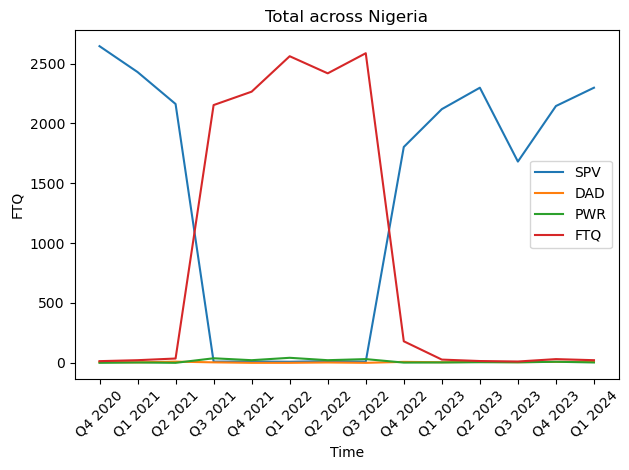

In [144]:
# trends in the features

for i in enumerate(features.drop('Other_Factors')):
    plt.subplot()
    plt.plot(groups.Quarter,groups[i[1]],label=i[1])
    plt.xticks(groups.Quarter,rotation=45)
    plt.title(f'Total across Nigeria')
    plt.xlabel('Time')
    plt.ylabel(i[1])
    plt.legend()
    plt.tight_layout()
    plt.plot()

The 1st plot above with respect to time shows that Total_Crashes (including other two possible target variables) have come down over time. The slope below is shown to be negative to solidify the point that such incidents are coming down (according to this extremely limited data). Also, the second graph above shows the variation of features across time.

In [131]:
# linear regression of Total_Crashes as a function of time

var_index = 0
X = np.arange(len(groups))
X = sm.add_constant(X)
X = pd.DataFrame(sm.add_constant(X),columns=['const','time'])
y = groups[variables[var_index]].to_list()
model = sm.OLS(y,X)
print(model.fit().summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.421
Model:                            OLS   Adj. R-squared:                  0.373
Method:                 Least Squares   F-statistic:                     8.719
Date:                Sun, 01 Sep 2024   Prob (F-statistic):             0.0121
Time:                        23:00:48   Log-Likelihood:                -99.021
No. Observations:                  14   AIC:                             202.0
Df Residuals:                      12   BIC:                             203.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       3482.4571    156.334     22.276      0.0

/home/user/anaconda3/lib/python3.11/site-packages/scipy/stats/_stats_py.py:1806: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=14
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "
